<a href="https://colab.research.google.com/github/mashaan14/VisionTransformer-MNIST/blob/main/VisionTransformer_MNIST_query_key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision transformers: attention maps for query and key images

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/y1ZmMcMYjkY).

## Acknowledgment:
I borrowed the transformer code from this link:
  - https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/11-vision-transformer.html

In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [ ]:
# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.MNIST(root='/data/torchvision/MNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 101491060.02it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]

Extracting /data/torchvision/MNIST/training/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27587204.21it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19031497.27it/s]


Extracting /data/torchvision/MNIST/training/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/training/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 84687139.07it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 4175077.34it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/train-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27826517.67it/s]


Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20116714.64it/s]

Extracting /data/torchvision/MNIST/testing/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/torchvision/MNIST/testing/MNIST/raw



In [ ]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'source_loader')
print_dim(val_loader,'source_eval_loader')
print_dim(test_loader,'target_loader')

---------source_loader---------
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------source_eval_loader---------
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------target_loader---------
torch.Size([32, 1, 28, 28])
torch.Size([32])


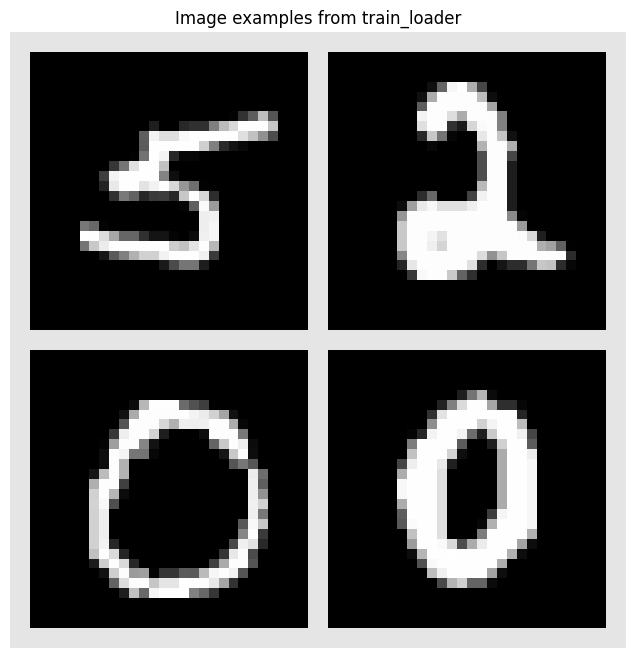

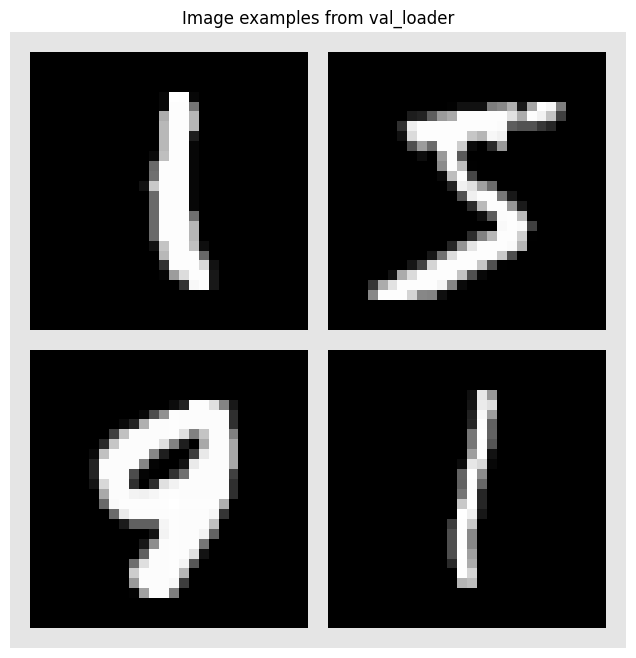

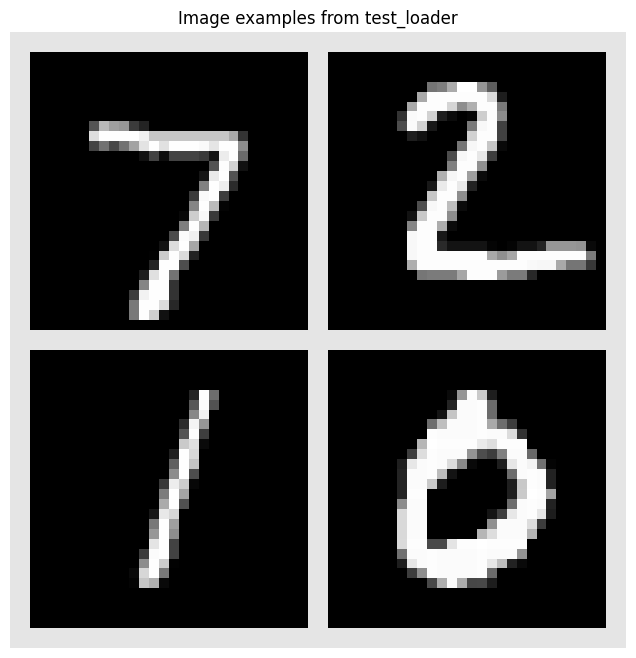

In [ ]:
# Visualize some examples from datasets
def plot_images(dataset, text):
  NUM_IMAGES = 4
  examples = torch.stack([dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
  img_grid = torchvision.utils.make_grid(examples, nrow=2, normalize=True, pad_value=0.9)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(8, 8))
  plt.title("Image examples from "+text)
  plt.imshow(img_grid)
  plt.axis("off")
  plt.show()
  plt.close()

plot_images(train_loader.dataset,'train_loader')
plot_images(val_loader.dataset,'val_loader')
plot_images(test_loader.dataset,'test_loader')

In [ ]:
image_size = 28
embed_dim=256
hidden_dim=embed_dim*3
num_heads=8
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

In [ ]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

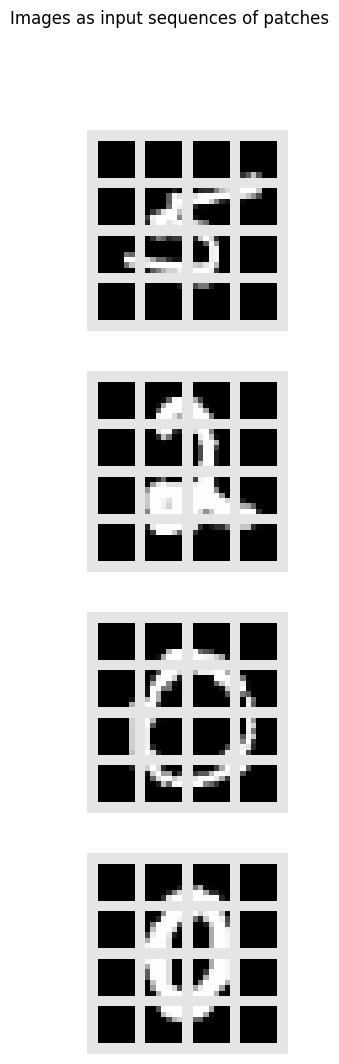

In [ ]:
# Visualize the image patches
NUM_IMAGES = 4
train_examples = torch.stack([train_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_patches = img_to_patch(train_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(train_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(train_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [ ]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True


# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)
# set a scheduler to decay the learning rate by 0.1 on the 100th 150th epochs
model_scheduler = optim.lr_scheduler.MultiStepLR(model_optimizer,
                                            milestones=[100, 150], gamma=0.1)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(20):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  model_scheduler.step()
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)


epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0780 valid 0.1464


epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3252 valid 0.1110


epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1648 valid 0.0994


epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0221 valid 0.0928


epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2347 valid 0.1080


epoch 5:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.2938 valid 0.0824


epoch 6:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0276 valid 0.0835


epoch 7:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0046 valid 0.0743


epoch 8:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.3361 valid 0.0721


epoch 9:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0047 valid 0.0757


epoch 10:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0042 valid 0.0790


epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0102 valid 0.0835


epoch 12:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0097 valid 0.0659


epoch 13:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0101 valid 0.0627


epoch 14:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0202 valid 0.0741


epoch 15:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0341 valid 0.0733


epoch 16:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0094 valid 0.0677


epoch 17:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0447 valid 0.0727


epoch 18:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.0219 valid 0.0730


epoch 19:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.1061 valid 0.0591


Text(0.5, 1.0, 'Training loss')

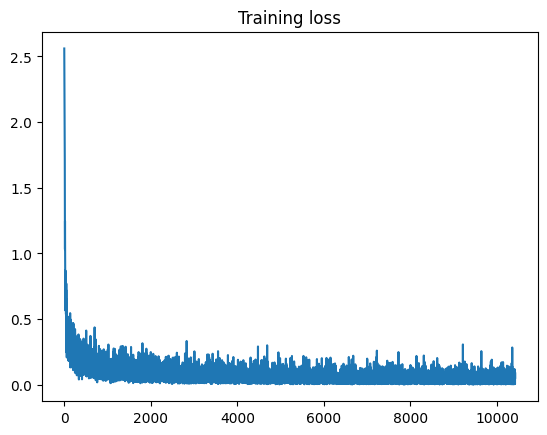

In [ ]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
# plot the average loss
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [ ]:
# Set the model to evaluation mode, disabling dropout.
model.eval()
# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.9827


In [ ]:
(test_set.targets==8).nonzero(as_tuple=True)[0][5]

tensor(146)

In [ ]:
# pull out two test samples
img_tensor_k = test_set.data[0].to(device)
img_tensor_q = test_set.data[146].to(device)
# convert the test sample into patches
patches_k = img_to_patch(img_tensor_k.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
patches_q = img_to_patch(img_tensor_q.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
# run the patches through the input layer to get a tensor of size embed_dim
patches_k_encoded = model.input_layer(patches_k.float())
patches_q_encoded = model.input_layer(patches_q.float())
q = patches_q_encoded
k = patches_k_encoded
att = q @ k.transpose(-2, -1)
print(q.shape)
print(k.shape)
print(att.squeeze().shape)

torch.Size([1, 16, 256])
torch.Size([1, 16, 256])
torch.Size([16, 16])


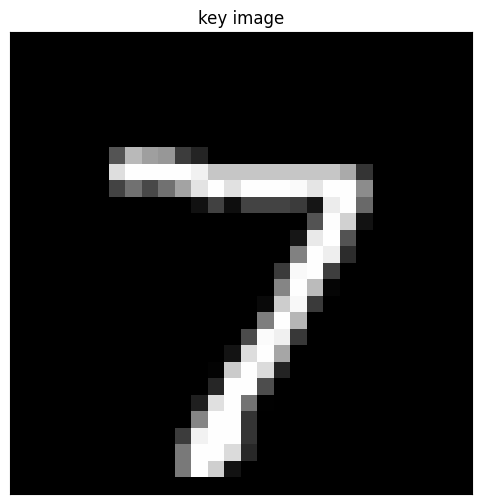

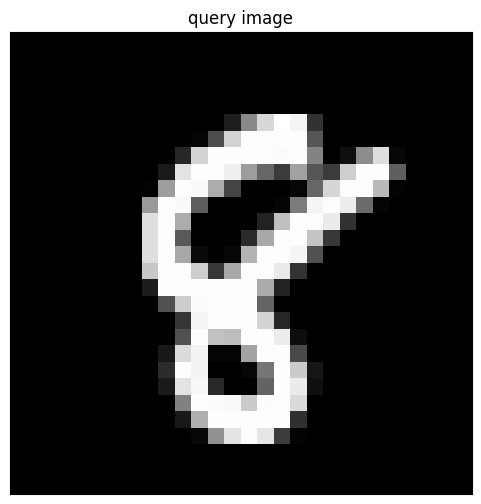

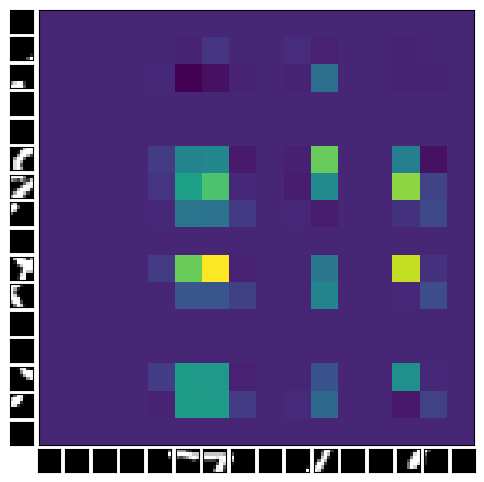

In [ ]:
patches_q_plot = patches_q.reshape(num_patches,num_channels,patch_size,patch_size).detach().cpu().numpy()
patches_k_plot = patches_k.reshape(num_patches,num_channels,patch_size,patch_size).detach().cpu().numpy()


fig = plt.figure(figsize=(6,6))
img = np.asarray(img_tensor_k.cpu())
plt.imshow(img, cmap='gray')
plt.title('key image')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.savefig('key.png', bbox_inches='tight', dpi=600)

fig = plt.figure(figsize=(6,6))
img = np.asarray(img_tensor_q.cpu())
plt.imshow(img, cmap='gray')
plt.title('query image')
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.savefig('query.png', bbox_inches='tight', dpi=600)


fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(17, 17, figure=fig)
ax3 = plt.subplot(gs[:-1, 1:])
ax3.matshow(att.detach().squeeze().cpu().numpy())
ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

for i in range(num_patches):
    ax = plt.subplot(gs[i, 0])
    ax.imshow(patches_q_plot[i,0,:,:], cmap='gray')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

for i in range(num_patches):
    ax = plt.subplot(gs[-1, i+1])
    ax.imshow(patches_k_plot[i,0,:,:], cmap='gray')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.savefig('att.png', bbox_inches='tight', dpi=600)


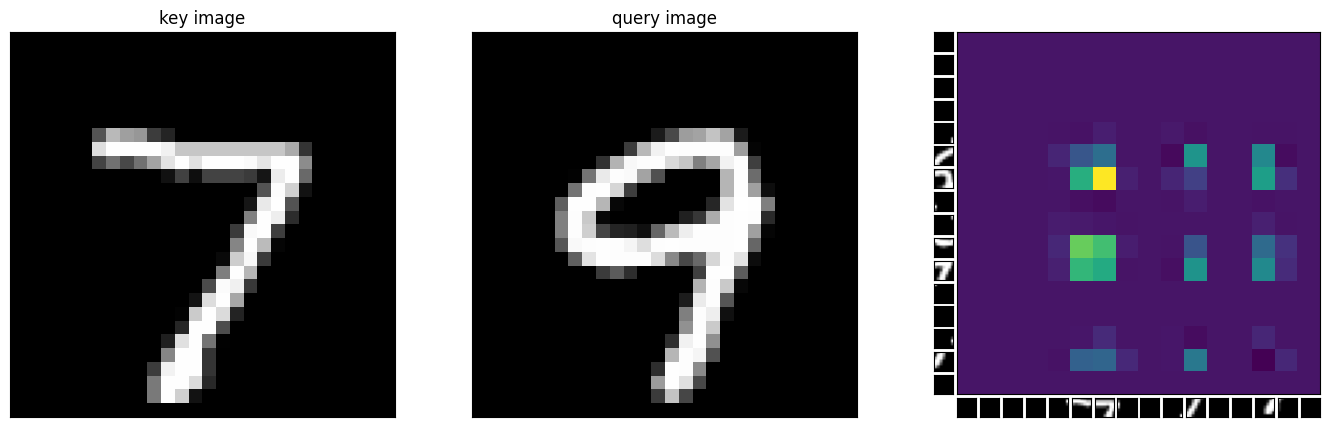

In [ ]:
fig = plt.figure(figsize=(16.9,5))
gs0 = gridspec.GridSpec(1, 3, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(17, 17, subplot_spec=gs0[0,2])

ax1 = fig.add_subplot(gs0[0, 0])
img = np.asarray(img_tensor_k.cpu())
ax1.imshow(img, cmap='gray')
ax1.set_title('key image')
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax2 = fig.add_subplot(gs0[0, 1])
img = np.asarray(img_tensor_q.cpu())
ax2.imshow(img, cmap='gray')
ax2.set_title('query image')
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
               labelbottom=False, labeltop=False, labelleft=False, labelright=False)

ax3 = plt.subplot(gs00[:-1, 1:])
ax3.matshow(att.detach().squeeze().cpu().numpy())
ax3.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

for i in range(num_patches):
    ax = plt.subplot(gs00[i, 0])
    ax.imshow(patches_q_plot[i,0,:,:], cmap='gray')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

for i in range(num_patches):
    ax = plt.subplot(gs00[-1, i+1])
    ax.imshow(patches_k_plot[i,0,:,:], cmap='gray')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)